
### Maintenance dredging due to keeping the port accessible

![Alt text](image-1.png)

* This notebook aims to formulate the port accessibility in openclsim simulation when addressing the interaction between one dredging vessel and one seagoing vessel.

* The concept of accessibility is defined based on the picture above. When the available water depth is higher than the required water depth for the seagoing vessel, the vessel can sail through the port. Otherwise, the dredging vessel should start its job and keep the port accessible by dredging a certain amount of sediment.

The following variables are used:

```
AWL: Actual (as in at this moment) Water Level (meters)
LAT: Lowest Astronomical Tide (meters)
MBL: Maintained Bed Level (meters)
T: Draught (meters)
```
Then the criteria for accessibility can be defined as follows.

* required water depth = ```T``` + safety margin for under keel clearance

* available water depth = ```AWL - MBL```

Considerations

*  A dredging criteria level is defined to determine a level that when reaches the ```MBL```, the dredging operation is triggered. Dredging criteria level is considered as a safety margin to guarantee the nautical depth. When this safety margin is lower than the ```MBL```, no dredging is needed and the location is accessible. Otherwise, dredging is triggered.

* Dredging criteria level depends on errors in surveys and uncertainties in dredging caused by different rates of sedimentation. 

* Dredging criteria level = ```MBL``` - errors in surveys - uncertainties in dredging (dredging tolerance)

* To dredge navigation channels, ```LAT``` can be ignored because navigation channels are designed based on ```LAT``` and no vessel has tidal windows. When sailing through channels, vessels sail during the neap tide and not tidal restriction is applied.

* For berth location, ```LAT``` is considered as one of the determining factors when the minimum water level is a bit lower than ```LAT```. In this case, vessels need to be at the port during the ebb tide. Dredging criteria level are also taken into account to determine how frequently the berth should be dredged.

#### 0. Import libraries

In [41]:
import datetime

import networkx as nx
import shapely
import shapely.geometry
import pyproj


import datetime as dt
import time
import simpy
import openclsim.core as core
import openclsim.model as model
import openclsim.plugins as plugin
import openclsim.plot as plot
import opentnsim

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objs as go
import folium

#### 1. Initialise simpy environment

In [42]:
# setup environment
simulation_start = 0
my_env = simpy.Environment(initial_time=simulation_start)

#### 2. Define object classes

In [43]:
# create a Site object based on desired mixin classes
Site = type(
    "Site",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasContainer,
        core.HasResource,
        core.HasActualWaterLevel,
        core.HasLowestAstronomicalTide,
        core.HasMaintainedBedLevel,
    ),
    {},
)

# create a TransportProcessingResource object based on desired mixin classes
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.ContainerDependentMovable,
        core.HasResource,
        core.HasContainer,
        core.Processor,
        core.Identifiable,
        core.Log,
        core.LoadingFunction,
        core.UnloadingFunction,
        core.HasDraught,  # adding the draught attibute for vessel objects
        # capture extra metadata to make sure we don't have leftover arguments
        opentnsim.core.ExtraMetadata,
    ),
    {},
)

#### 3. Create objects

##### 3.1. Create site objects

<Axes: xlabel='date'>

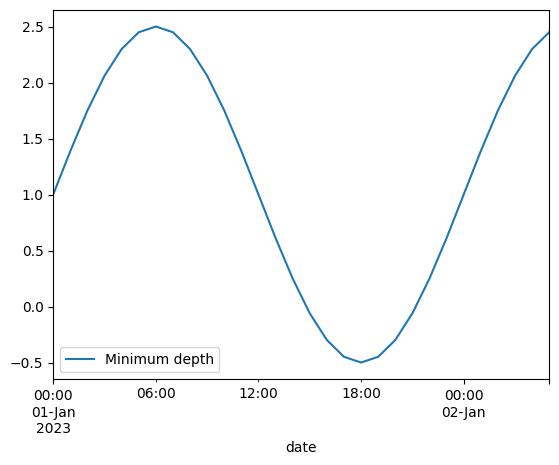

In [44]:
# define a tidal water level

dates = pd.date_range(start=datetime.datetime(2023, 1, 1), end=datetime.datetime(2023, 2, 1), freq='H')
len(dates)
depth_df = pd.DataFrame({"date": dates})
ts = depth_df['date'].apply(lambda t: t.timestamp())
depth_df['ts'] = ts
depth_df['ts_h'] = depth_df['ts'] / 3600

amplitude = 1.5
# TODO: What is this base level?
base_level = 1
# TODO: translate water level to minimum depth
minimum_depth = amplitude * np.sin(1/12 * depth_df['ts_h'] * np.pi) + base_level

depth_df['Minimum depth'] = minimum_depth

depth_df[:30].plot('date', 'Minimum depth')

In [45]:
depth_df.head(10)

,date,ts,ts_h,Minimum depth
0,2023-01-01 00:00:00,1.672531e+09,464592.0,1.000000
1,2023-01-01 01:00:00,1.672535e+09,464593.0,1.388229
2,2023-01-01 02:00:00,1.672538e+09,464594.0,1.750000
3,2023-01-01 03:00:00,1.672542e+09,464595.0,2.060660
4,2023-01-01 04:00:00,1.672546e+09,464596.0,2.299038
5,2023-01-01 05:00:00,1.672549e+09,464597.0,2.448889
6,2023-01-01 06:00:00,1.672553e+09,464598.0,2.500000
7,2023-01-01 07:00:00,1.672556e+09,464599.0,2.448889
8,2023-01-01 08:00:00,1.672560e+09,464600.0,2.299038
9,2023-01-01 09:00:00,1.672564e+09,464601.0,2.060660


In [46]:
loading_crit = plugin.DepthCriterion(
    name="loading_crit",
    condition="Minimum depth",
    minimum=1, # for now we assume that 1 m waterdepth is the minimum depth for economic accomodation of draught + ukc + margin
    window_length=3600,
)
loading_crit


sailing_crit = plugin.DepthCriterion(
    name="sailing_crit",
    condition="Minimum depth",
    minimum=1, # for now we assume that 1 m waterdepth is the minimum depth for economic accomodation of draught + ukc + margin
    window_length=3600,
)
sailing_crit

In [47]:
# prepare input data for offshore
location_offshore = shapely.geometry.Point(3.637610458072877, 52.10701582514347)
data_offshore = {
    "env": my_env,
    "name": "offshore",
    "geometry": location_offshore,
    "capacity": 100,
    "level": 0,
    "AWL": -0.13,
    "LAT": -0.92,
    "MBL": -17,
}
offshore = Site(**data_offshore)

# prepare input data for berth
location_berth = shapely.geometry.Point(4.062705498083785, 51.95909715255291)
data_berth = {
    "env": my_env,
    "name": "berth",
    "geometry": location_berth,
    "capacity": 100,
    "level": 80,
    "nr_resources": 1,
    "AWL": -0.13,
    "LAT": -0.92,
    "MBL": -17,
}
berth = Site(**data_berth)

# prepare input data for dump
location_dump = shapely.geometry.Point(4.1795229742823, 52.11590591837503)
data_dump = {
    "env": my_env,
    "name": "dump",
    "geometry": location_dump,
    "capacity": 100,
    "level": 0,
    "AWL": -0.13,
    "LAT": -0.92,
    "MBL": -17,
}
dump = Site(**data_dump)

##### 3.2. Create vessel objects

In [48]:
# prepare input data for vessel_01 (dredging vessel)
data_vessel01 = {
    "env": my_env,
    "name": "dredging vessel",
    "geometry": location_dump,
    "capacity": 10,
    "loading_rate": 1,
    "unloading_rate": 0.5,
    "compute_v": lambda x: 10 + 2 * x,
    "draught": 10,
}
# instantiate vessel_01
vessel01 = TransportProcessingResource(**data_vessel01)
assert not vessel01.metadata


# prepare input data for vessel_02 (seagoing vessel)
data_vessel02 = {
    "env": my_env,
    "name": "seagoing vessel",
    "geometry": location_offshore,
    "capacity": 10,
    "level": 5,
    "loading_rate": 1,
    "unloading_rate": 0.5,
    "compute_v": lambda x: 15 + 2 * x,
    "draught": 15,
}
# instantiate vessel_02
vessel02 = TransportProcessingResource(**data_vessel02)
assert not vessel02.metadata

##### 3.3. Creat activity objects

In [49]:
# Initialise registry
registry = {}

In [50]:
# Define custom activities with Depth Plugin
ShiftAmountWithDepthActivity = type(
    "ShiftAmountWithDepthActivity",
    (
        plugin.HasDepthPluginActivity,
        model.ShiftAmountActivity,
    ),
    {},
)

MoveWithDepthActivity = type(
    "MoveWithDepthActivity",
    (
        plugin.HasDepthPluginActivity,
        model.MoveActivity,
    ),
    {},
)

In [51]:
# Specify the amount of container and duration of activities
amount = 10
duration = 200

# Specify dredging subprocesses
dredging_subprocesses = [
    MoveWithDepthActivity(
        env=my_env,
        name="sailing empty dredging vessel",
        registry=registry,
        mover=vessel01,
        destination=berth,
        depth_criteria=sailing_crit,
        depth_df=depth_df
    ),
    ShiftAmountWithDepthActivity(
        env=my_env,
        name="loading dredging vessel",
        registry=registry,
        processor=vessel01,
        origin=berth,
        destination=vessel01,
        amount=amount,
        duration=50 * amount,
        depth_criteria=loading_crit,
        depth_df=depth_df
    ),
    MoveWithDepthActivity(
        env=my_env,
        name="sailing full dredging vessel",
        registry=registry,
        mover=vessel01,
        destination=dump,
        depth_criteria=sailing_crit,
        depth_df=depth_df
    ),
    ShiftAmountWithDepthActivity(
        env=my_env,
        name="unloading dredging vessel",
        registry=registry,
        processor=vessel01,
        origin=vessel01,
        destination=dump,
        amount=amount,
        duration=20 * amount,
        depth_criteria=loading_crit,
        depth_df=depth_df
    ),
]

# Define activities of the dredging vessel
activities_dredging_vessel = model.WhileActivity(
    env=my_env,
    name="while sequential activity dredging vessel",
    registry=registry,
    sub_processes=[
        model.SequentialActivity(
            env=my_env,
            name=f"sequential activity subcycle dredging vessel",
            registry=registry,
            sub_processes=dredging_subprocesses,
        )
    ],
    condition_event=[
        {
            "type": "container",
            "concept": berth,
            "state": "empty",
            "id_": "default_reservations",
        }
    ],
)

In [52]:
# Specify seagoing subprocesses
requested_resources = {}
seagoing_subprocesses = [
    model.BasicActivity(
        env=my_env, name="interval time", registry=registry, duration=200
    ),
    MoveWithDepthActivity(
        env=my_env,
        name="sailing full seagoing vessel",
        registry=registry,
        mover=vessel02,
        destination=berth,
        depth_criteria=loading_crit,
        depth_df=depth_df
    ),
    ShiftAmountWithDepthActivity(
        env=my_env,
        name="unloading seagoing vessel",
        registry=registry,
        processor=vessel02,
        origin=vessel02,
        destination=berth,
        amount=amount,
        duration=30 * amount,
        requested_resources=requested_resources,
        depth_criteria=loading_crit,
        depth_df=depth_df
    ),
    MoveWithDepthActivity(
        env=my_env,
        name="sailing empty seagoing vessel",
        registry=registry,
        mover=vessel02,
        destination=offshore,
        depth_criteria=loading_crit,
        depth_df=depth_df
    ),
]

# Define activities of the seagoing vessel
activities_seagoing_vessel = model.WhileActivity(
    env=my_env,
    name="while sequential activity dredging vessel",
    registry=registry,
    sub_processes=seagoing_subprocesses,
    condition_event=[
        {
            "type": "container",
            "concept": vessel02,
            "state": "empty",
            "id_": "default_reservations",
        }
    ],
)

#### 4. Register activities and run simpy

In [53]:
# register dredging activities
model.register_processes([activities_dredging_vessel])

# register seagoing activities
model.register_processes([activities_seagoing_vessel])

In [54]:
my_env.run()

mover dredging vessel destination berth
mover seagoing vessel destination berth
updating to destination geometry POINT (4.062705498083785 51.95909715255291)
updating to destination geometry POINT (4.062705498083785 51.95909715255291)
mover dredging vessel destination dump
mover seagoing vessel destination offshore
updating to destination geometry POINT (4.1795229742823 52.11590591837503)
mover dredging vessel destination berth
updating to destination geometry POINT (3.637610458072877 52.10701582514347)
updating to destination geometry POINT (4.062705498083785 51.95909715255291)
mover dredging vessel destination dump
updating to destination geometry POINT (4.1795229742823 52.11590591837503)
mover dredging vessel destination berth
updating to destination geometry POINT (4.062705498083785 51.95909715255291)
mover dredging vessel destination dump
updating to destination geometry POINT (4.1795229742823 52.11590591837503)
mover dredging vessel destination berth
updating to destination geomet

#### 5. Inspect results

##### 5.1. Inspect logs

In [55]:
# Inspect dredging vessel log
display(plot.get_log_dataframe(vessel01, [activities_dredging_vessel]))

,Activity,Timestamp,ActivityState,geometry,container level
0,sailing empty dredging vessel,2023-01-01 01:00:00.000000,START,POINT (4.1795229742823 52.11590591837503),0.0
1,sailing empty dredging vessel,2023-01-01 01:32:00.113019,STOP,POINT (4.062705498083785 51.95909715255291),0.0
2,loading dredging vessel,2023-01-01 01:32:00.113019,START,POINT (4.062705498083785 51.95909715255291),0.0
3,loading dredging vessel,2023-01-01 01:40:20.113019,STOP,POINT (4.062705498083785 51.95909715255291),10.0
4,sailing full dredging vessel,2023-01-01 01:40:20.113019,START,POINT (4.062705498083785 51.95909715255291),10.0
...,...,...,...,...,...
67,loading dredging vessel,2023-01-01 11:03:01.770623,STOP,POINT (4.062705498083785 51.95909715255291),5.0
68,sailing full dredging vessel,2023-01-01 11:03:01.770623,START,POINT (4.062705498083785 51.95909715255291),5.0
69,sailing full dredging vessel,2023-01-01 11:32:07.327912,STOP,POINT (4.1795229742823 52.11590591837503),5.0
70,unloading dredging vessel,2023-01-01 11:32:07.327912,START,POINT (4.1795229742823 52.11590591837503),5.0


In [56]:
# Inspect seagoing vessel log
display(plot.get_log_dataframe(vessel02, [activities_seagoing_vessel]))

,Activity,Timestamp,ActivityState,geometry,container level
0,sailing full seagoing vessel,2023-01-01 01:00:00.000000,START,POINT (3.637610458072877 52.10701582514347),5
1,sailing full seagoing vessel,2023-01-01 01:34:53.474628,STOP,POINT (4.062705498083785 51.95909715255291),5
2,unloading seagoing vessel,2023-01-01 01:40:20.113019,START,POINT (4.062705498083785 51.95909715255291),5
3,unloading seagoing vessel,2023-01-01 01:45:20.113019,STOP,POINT (4.062705498083785 51.95909715255291),0
4,sailing empty seagoing vessel,2023-01-01 01:45:20.113019,START,POINT (4.062705498083785 51.95909715255291),0
5,sailing empty seagoing vessel,2023-01-01 02:22:33.152622,STOP,POINT (3.637610458072877 52.10701582514347),0


##### 5.2. Visualize gantt chart

In [57]:
res = plot.get_gantt_chart([vessel01, vessel02], y_scale="numbers", static=True, id_map=[activities_dredging_vessel, activities_seagoing_vessel])
data = res['data']
layout = res['layout']

data.append({
    "name": "sailing_crit",
    "x":[vessel01.log["Timestamp"][0].isoformat(), vessel01.log["Timestamp"][-1].isoformat()],
    "y":[sailing_crit.minimum,sailing_crit.minimum],
})
data.append({
    "name": "sailing_crit",
    "x":[vessel02.log["Timestamp"][0].isoformat(), vessel02.log["Timestamp"][-1].isoformat()],
    "y":[sailing_crit.minimum,sailing_crit.minimum],
})


data.append({
    "name": "Depth",
    "x":depth_df.index,
    "y":depth_df[sailing_crit.condition],
})


data.append({
    "name": "loading_crit",
    "x":[vessel01.log["Timestamp"][0].isoformat(), vessel01.log["Timestamp"][-1].isoformat()],
    "y":[loading_crit.minimum,loading_crit.minimum],
})
data.append({
    "name": "loading_crit",
    "x":[vessel02.log["Timestamp"][0].isoformat(), vessel02.log["Timestamp"][-1].isoformat()],
    "y":[loading_crit.minimum,loading_crit.minimum],
})

go.Figure(data=data, layout=layout)

In [58]:
plot.get_gantt_chart(
    [vessel01, vessel02],
    id_map=[activities_dredging_vessel, activities_seagoing_vessel],
)

##### 5.3. Visualize container volume developments

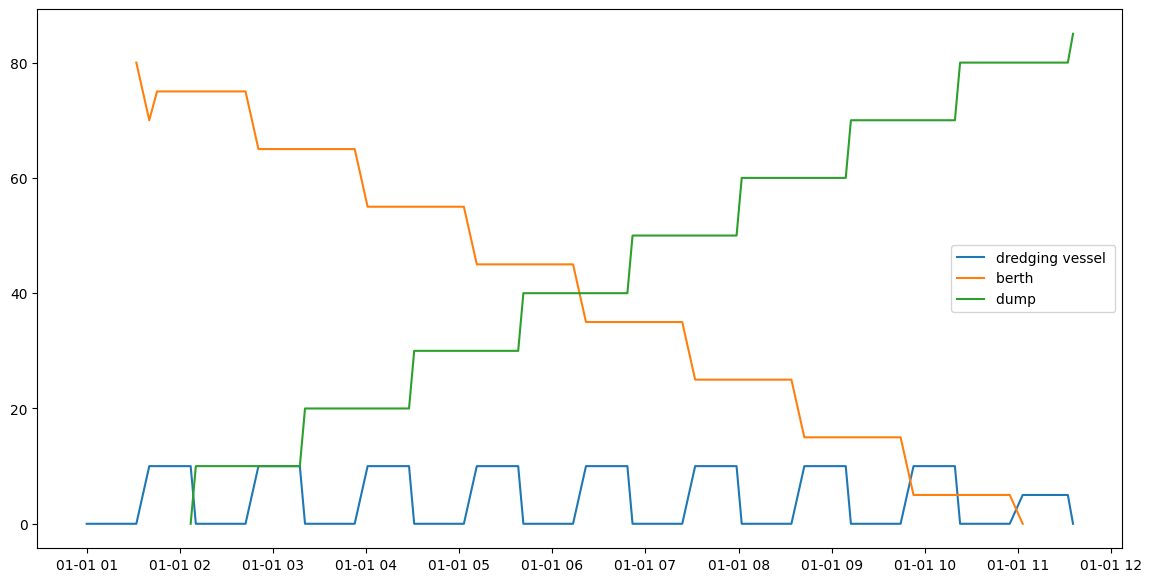

In [59]:
fig = plot.get_step_chart([vessel01, berth, dump])

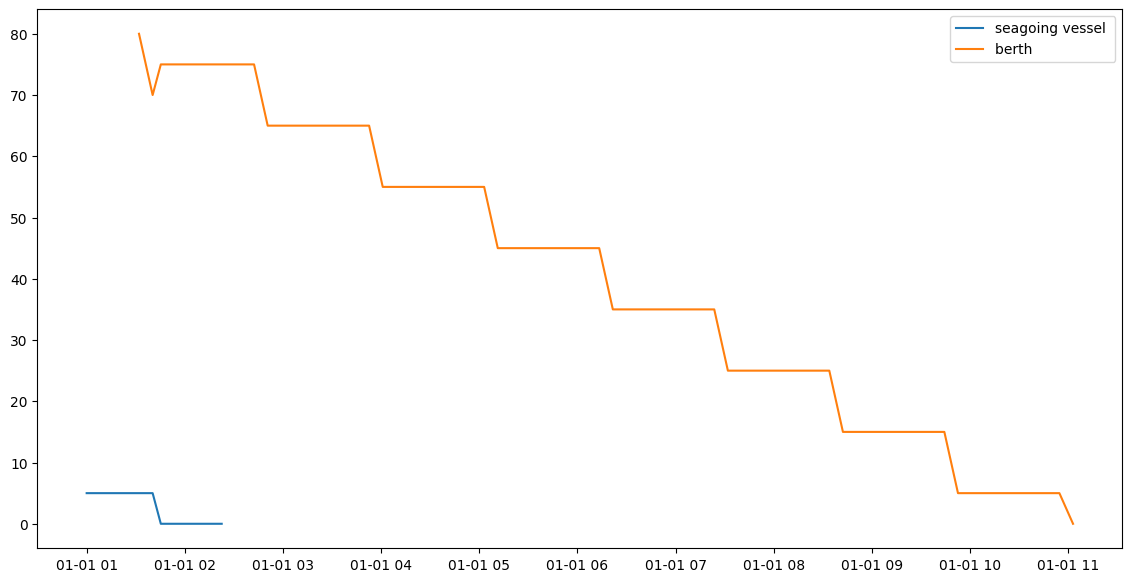

In [60]:
fig = plot.get_step_chart([vessel02, berth, offshore])